In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import edrixs

# energy parameters
J = 3
V = 2
Gamma = 1

# spin matrix
chi = np.array([[0,1],[1,0]])

# number of sites
nsite = 2

# number of orbitals per site per spin
norb_per_site_per_spin = 1

# number of orbitals in total per spin
norb_per_spin = norb_per_site_per_spin * nsite

# number of orbitals per site, including the spin degrees of freedom
norb_per_site = 2 * norb_per_site_per_spin

# number of orbitals in total, including the spin degrees of freedom
# we first count over spins, then count over orbitals, and then count over sites, consistent with edrixs
norb = norb_per_site * nsite

# list of states
state_list = []
for i in range(norb+1):
    state_list.append(edrixs.get_fock_bin_by_N(norb,i))
state = sum(state_list,[])

# number of states
nstates = len(state)

# annihilation and creation operators
# number operator
d_m = []
d_p = []
n_op = []
for i in range(norb):
    d_temp = edrixs.one_fermion_annihilation(i, state, state)
    d_m.append(d_temp)
    d_p.append(np.conjugate(d_temp.T))
    n_op.append(np.matmul(np.conjugate(d_temp.T), d_temp))
    
# function to give the orbital index
def get_orb_index(spin, orbital, site):
    if (spin <2 and orbital < norb_per_site_per_spin and site < nsite):
        orb_index = norb_per_site * site + 2 * orbital + spin
        return orb_index
    else:
        print('wrong input')
        return -1

def get_orb_index_per_spin(orbital, site):
    if (orbital < norb_per_site_per_spin and site < nsite):
        orb_index = norb_per_site_per_spin * site + orbital
        return orb_index
    else:
        print('wrong input')
        return -1

# function to give separate indices
def get_index(orb_index):
    if (orb_index < norb):
        temp = orb_index % (norb_per_site)
        site = orb_index // (norb_per_site)
        spin = temp % 2
        orbital = temp // 2
        return [spin, orbital, site]
    else:
        print('wrong input')
        return -1
def get_index_per_spin(orb_index):
    if (orb_index < norb_per_spin):
        site = orb_index // (norb_per_site_per_spin)
        orbital = orb_index % (norb_per_site_per_spin)
        return [orbital, site]
    else:
        print('wrong input')
        return -1

# operators labelled by orbital index (spin is summed over)
Sz_orb = []
Sp_orb = []
Sm_orb = []
n_orb = []
for i in range(norb_per_spin):
    [orbital, site] = get_index_per_spin(i)
    Sz_temp = 0.5 * (n_op[get_orb_index(0, orbital, site)] - n_op[get_orb_index(1, orbital, site)])
    Sp_temp = np.matmul(d_p[get_orb_index(0, orbital, site)], d_m[get_orb_index(1, orbital, site)])
    Sm_temp = np.matmul(d_p[get_orb_index(1, orbital, site)], d_m[get_orb_index(0, orbital, site)])
    n_temp = (n_op[get_orb_index(0, orbital, site)] + n_op[get_orb_index(1, orbital, site)])
    Sz_orb.append(Sz_temp)
    Sp_orb.append(Sp_temp)
    Sm_orb.append(Sm_temp)
    n_orb.append(n_temp)

# operators labelled by site index (spin and orbital per site is summed over)
Sz_site = []
Sp_site = []
Sm_site = []
n_site = []
for i in range(nsite):
    Sz_temp = np.zeros([nstates,nstates],dtype='complex128')
    Sp_temp = np.zeros([nstates,nstates],dtype='complex128')
    Sm_temp = np.zeros([nstates,nstates],dtype='complex128')
    n_temp = np.zeros([nstates,nstates],dtype='complex128')
    for j in range(norb_per_site_per_spin):
        orb_index = get_orb_index_per_spin(j, i)
        Sz_temp += Sz_orb[orb_index]
        Sp_temp += Sp_orb[orb_index]
        Sm_temp += Sm_orb[orb_index]
        n_temp += n_orb[orb_index]
    Sz_site.append(Sz_temp)
    Sp_site.append(Sp_temp)
    Sm_site.append(Sm_temp)
    n_site.append(n_temp)
    
# number operators by site index and spin index
n_site_spin = []
for i in range(nsite):
    for j in range(2):
        n_temp = np.zeros([nstates,nstates],dtype='complex128')
        for k in range(norb_per_site_per_spin):
            orb_index = get_orb_index(j, k, i)
            n_temp += n_op[orb_index]
        n_site_spin.append(n_temp)

In [2]:
# initial Hamiltonian for dimer
SS = 0.5*np.matmul(Sp_site[0],Sm_site[1])+0.5*np.matmul(Sm_site[0],Sp_site[1])+np.matmul(Sz_site[0],Sz_site[1])
H_initial = J*SS

In [3]:
# intermediate Hamiltonian for dimer
H_inter = []
for i in range(nsite):
    H_temp = H_initial - V * n_site[i]
    H_inter.append(H_temp)

In [4]:
# RIXS operator labelled by site
def A_rixs_site(site, omega, q):
    position = site - (nsite-1.0)/2
    factor = np.exp(1j * position * q)
    A = np.zeros([nstates, nstates],dtype='complex128')
    H_inv = scipy.linalg.inv((omega+0.5*1j*Gamma)*np.identity(nstates)-H_inter[site])
    for i in range(2):
        for j in range(2):
            for k in range(norb_per_site_per_spin):
                orb_index_1 = get_orb_index(i, k, site)
                orb_index_2 = get_orb_index(j, k, site)
                A += chi[i][j]* np.matmul(d_m[orb_index_1],np.matmul(H_inv,d_p[orb_index_2]))
    return A*factor

def A_ReIm_site(site, omega, q):
    A = A_rixs_site(site, omega, q)
    return [0.5*(A + np.conjugate(A.T)), -0.5*1j*(A - np.conjugate(A.T))]

# RIXS operator summed over site
def A_rixs(omega, q):
    A = np.zeros([nstates,nstates],dtype='complex128')
    for i in range(nsite):
        A += A_rixs_site(i, omega, q)
    return A

def A_ReIm(omega, q):
    A = A_rixs(omega, q)
    return [0.5*(A + np.conjugate(A.T)), -0.5*1j*(A - np.conjugate(A.T))]

# QFI denominator
def a_site(site, omega, q):
    A_re, A_im = A_ReIm_site(site, omega, q)
    e_re = scipy.linalg.eigvals(A_re).real
    e_im = scipy.linalg.eigvals(A_im).real
    return [np.max(e_re)-np.min(e_re), np.max(e_im)-np.min(e_im)]

def QFI_den(omega, q):
    a = 0
    for i in range(nsite):
        re, im = a_site(i, omega, q)
        a += re ** 2 + im **2
    return a

# QFT for specific state
def QFI_state(vector, omega, q):
    A_Re, A_Im = A_ReIm(omega, q)
    A_Re_square = np.matmul(A_Re, A_Re)
    A_Im_square = np.matmul(A_Im, A_Im)
    QFI = np.matmul(vector, np.matmul(A_Re_square, vector)) \
            + np.matmul(vector, np.matmul(A_Im_square, vector)) \
            - np.matmul(vector, np.matmul(A_Re, vector)) ** 2 \
            - np.matmul(vector, np.matmul(A_Im, vector)) ** 2
    QFI = 4 * QFI / QFI_den(omega, q)
    return QFI.real

# above has repeated calculation, we can avoid it by grouping all these functions into a single function

In [5]:
e, v = np.linalg.eigh(H_initial)

In [6]:
data = []
for i in np.arange(-6,-1,0.1):
    data.append((i, QFI_state(v[:,0], i, np.pi-0.3)))

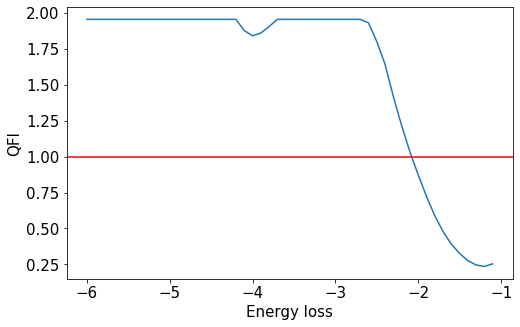

In [7]:
mpl.rcParams['font.size'] = 15
fig = plt.figure(figsize=(8, 5))
plt.plot(*zip(*data))
plt.xlabel(r'Energy loss')
plt.ylabel(r'QFI')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()